In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter


In [2]:
file_path = 'C:/Users/Lubin/Desktop/code/wattsonthemoon/data/three_hour_test_1-04-21T1402/three_hour_test_1.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

In [3]:
source_in_current = df[["Source in Current (A)"]].to_numpy() # Transmit end 120V in Nasa source
source_in_voltage = df[["Source in Voltage (V)"]].to_numpy()
bcm_lv_in_voltage = df[["BCM LV IN Voltage (V)"]].to_numpy() # Transmit end BCM low voltage input
bcm_lv_in_current = df[["BCM LV IN Current (A)"]].to_numpy()
transmit_battery_voltage = df[["Transmit Battery Voltage (V)"]].to_numpy() # Transmit end 48V battery pack
transmit_battery_current = df[["Transmit Battery Current (A)"]].to_numpy()
line_voltage_400 = df[["400 Line Voltage (V)"]].to_numpy() # Transmit end 400V line out of board
line_current_400 = df[["400 Line Current (A)"]].to_numpy()
load_side_voltage = df[["Load Side Voltage (V)"]].to_numpy()
load_side_current = df[["Load Side Current (A)"]].to_numpy()
load_battery_voltage = df[["Load Battery Voltage (V)"]].to_numpy()
load_battery_current = df[["Load Battery Current (A)"]].to_numpy()
bcm_voltage_in = df[["BCM Voltage In (V)"]].to_numpy()
bcm_voltage_out = df[["BCM Voltage Out (V)"]].to_numpy()
bcm_current_in = df[["BCM Current In (A)"]].to_numpy()
bcm_current_out_1 = df[["BCM Current Out (A)"]].to_numpy()
source_victron_voltage_1 = df[["Source Victron Voltage (V)"]].to_numpy() # Transmit end Victron
source_victron_current = df[["Source Victron Current (A)"]].to_numpy()
source_victron_vpv = df[["Source Victron VPV (V)"]].to_numpy()
source_victron_wpv = df[["Source Victron WPV (W)"]].to_numpy()
load_victron_voltage = df[["Load Victron Voltage (V)"]].to_numpy() # Load end Victron
load_victron_current = df[["Load Victron Current (A)"]].to_numpy()
load_victron_vpv = df[["Load Victron VPV (V)"]].to_numpy()
load_victron_wpv = df[["Load Victron WPV (W)"]].to_numpy()
bk_load_voltage = df[["BK Load Voltage (V)"]].to_numpy()
bk_load_current = df[["BK Load Current (A)"]].to_numpy()
bk_load_power_1 = df[["BK Load Power (W)"]].to_numpy()
ps_voltage_1 = df[["PS Voltage (V)"]].to_numpy()
ps_current = df[["PS Current (A)"]].to_numpy()
ps_power = df[["PS Power (W)"]].to_numpy()

In [4]:

def calc_strings(df, full_time):
        lenn = len(df["Time"]) - 1
        power_in = round(df['Source in Voltage (V)'][lenn] * df['Source in Current (A)'][lenn], 2)
        power_out = round( df['BK Load Power (W)'][lenn], 2)
        time_elapsed = round(df['Time'][lenn], 1)

        power_400 = round(df['400 Line Voltage (V)'][lenn] * df['400 Line Current (A)'][lenn], 2)
        source_batt = round(df['Transmit Battery Voltage (V)'][lenn], 2)
        load_batt = round(df['BK Load Voltage (V)'][lenn], 2)
        load_batt_per_cell = round(load_batt/7, 2)
        source_batt_per_cell = round(source_batt/13, 2)

        string1 = f'Watts on on the Moon {full_time} min test Full Profile Data \n'
        string2 = f'Power in: {power_in} W | Power out: {power_out} | 400 Line Power: {power_400} W | Time Elapsed: {time_elapsed} mins \n'
        string3 = f'Source Battery: {source_batt} V | Load Battery: {load_batt} V | Load Battery per cell: {load_batt_per_cell} V | Source Battery per cell: {source_batt_per_cell} V'
        return string1, string2, string3

# Calculating energies
def calc_energy( voltage, current, time, list):
    # Create a dictionary to access each dictionary 
    dict = {
        "energy in": energy_in,
        "energy out": energy_out
    }
    list = dict[list]
    if len(list) == 0:
        list.append(0)
    else:
        current_index = len(list)
        previous_value = list[current_index - 1]
        h = (time[current_index] - time[current_index - 1])/60
        if current_index % 2 == 0:
            val = (h/3) * 4 * (voltage[current_index] * current[current_index])
            val = val + previous_value
            list.append(val)
        else:
            val = (h/3) * 2 * (voltage[current_index] * current[current_index])
            val = val + previous_value
            list.append(val)


def psuedo_calc(voltage, current, time):
    list = []
    dummy_val  = 0
    for i in range(len(voltage)):
        if i == 0:
            list.append(0)
        else:
            h = (time[i] - time[i-1]) /(60) # Gets the time difference in hours
            if i % 2 == 0:
                val = (h/3) *4 * voltage[i] * current[i] 
                val = val + dummy_val # append it
                dummy_val = val # Stores the previous value
                list.append(val)
            else:
                val = (h/3) *2 * voltage[i] * current[i] 
                val = val + dummy_val
                dummy_val = val
                list.append(val)
    #print(list)
    return list

def add_initial_energy(voltage, batt):
    dict = {"Source": [1440, 13], "Load": [720, 7]}
    capacity = dict[batt][0]
    num_cells = dict[batt][1]
    starting_v_per_cell = voltage[0] / num_cells
    starting_capacity = capacity * (starting_v_per_cell -3.2) / 0.9
    #print(starting_capacity)
    return starting_capacity

def psuedo_calc_batt(voltage, current, time, inital_energy, batt):
    dict = {"Source": [1440], "Load": [720]}
    capacity = dict[batt][0]
    list = []
    dummy_val  = 0
    for i in range(len(voltage)):
        if i == 0:
            list.append(inital_energy)
            dummy_val = inital_energy
        else:
            h = (time[i] - time[i-1]) /(60) # Gets the time difference in hours
            if i % 2 == 0:
                val = (h/3) *4 * voltage[i] * current[i] 
                # Convert from array to float
                
                val = val + dummy_val # append it
                val = val + 0
                if val > capacity:
                    val = capacity
                
                dummy_val = val # Stores the previous value
                list.append(val)
            else:
                val = (h/3) *2 * voltage[i] * current[i]
                val = val + dummy_val
                if val > capacity:
                    val = capacity
                dummy_val = val
                list.append(val)
    #print(list)
    return list


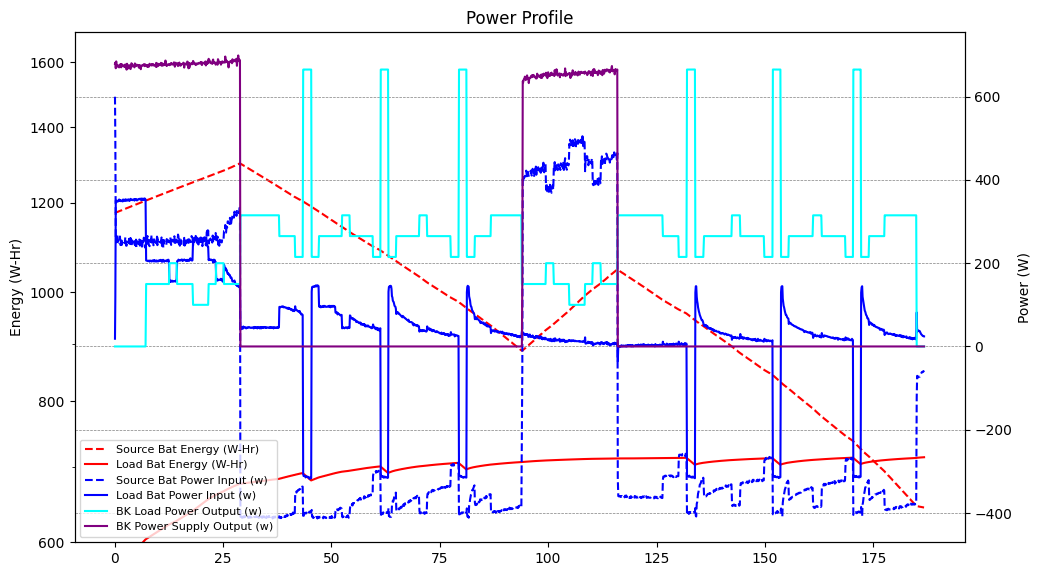

In [6]:
# Plot 1 - Full Profile

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_yscale('log')
fig.subplots_adjust(left=0.08, right=.97, bottom=0.05, top=0.9, wspace=0.25, hspace=0.25)


# Customize y-axis ticks using LogLocator and LogFormatter
log_locator = LogLocator(base=10, subs=[1, 2, 3, 4, 5, 6, 7, 8, 9])
log_formatter = LogFormatter(base=10)
ax1.yaxis.set_major_locator(log_locator)
ax1.yaxis.set_major_formatter(log_formatter)
ax1.set_yticks([600, 0.8*10**3, 1000, 1200, 1400, 1600])
ax1.set_yticklabels([600, 800, 1000, 1200, 1400, 1600])

list = psuedo_calc_batt(df['Transmit Battery Voltage (V)'], df["Transmit Battery Current (A)"], df["Time"], add_initial_energy(df['Transmit Battery Voltage (V)'], "Source"), "Source")
line1, = ax1.plot(df["Time"], list, label="Source Bat Energy (W-Hr)", color="red", linestyle="dashed")
list = psuedo_calc_batt(df["Load Battery Voltage (V)"], df["Load Battery Current (A)"], df["Time"], add_initial_energy(df["Load Battery Voltage (V)"], "Load"), "Load")

line2, = ax1.plot(df["Time"], list, label="Load Bat Energy (W-Hr)", color="red")
ax1.set_ylim([600, 1700])
ax1.set_ylabel("Energy (W-Hr)")
ax1.grid(False)
ax2 = ax1.twinx()
line3, = ax2.plot(df["Time"], np.multiply(df["Transmit Battery Voltage (V)"], df["Transmit Battery Current (A)"]), label="Source Bat Power Input (w)", color="blue", linestyle="dashed")  # Plot the updated data
line4, =ax2.plot(df["Time"], np.multiply(df['Load Battery Voltage (V)'], df["Load Battery Current (A)"]), label="Load Bat Power Input (w)", color="blue")  # Plot the updated data
# Convert this: .plot(bk_load_power_1, label="Load Power Output (w)", color="cyan")
line5, = ax2.plot(df["Time"], df['BK Load Power (W)'], label="BK Load Power Output (w)", color="cyan")  # Plot the updated data
line6, = ax2.plot(df["Time"], df['PS Power (W)'], label="BK Power Supply Output (w)", color="purple")  # Plot the updated data
ax2.set_xlabel('Time (Min)')  # Set the x-axis label
ax2.set_ylabel('Power (W)')  # Set the y-axis label
ax2.set_title('Power Profile')  # Set the title
ax2.grid(True, color='gray', linestyle='--', linewidth=0.5)

lines = [line1, line2, line3, line4, line5, line6]
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc="lower left", prop={'size': 8} )  # Add a legend

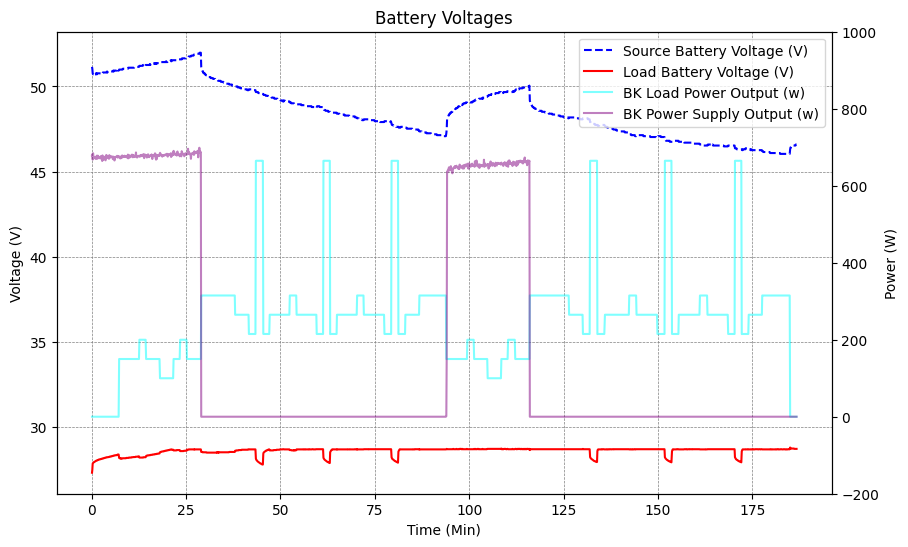

In [26]:
# Plot 2 - Battery Voltages
fig, ax = plt.subplots(figsize=(10, 6))
line1, = ax.plot(df["Time"], df["Transmit Battery Voltage (V)"], label="Source Battery Voltage (V)", color="blue", linestyle="dashed")  # Plot the updated data
line2, = ax.plot(df["Time"], df['Load Battery Voltage (V)'], label="Load Battery Voltage (V)", color="red")  # Plot the updated data
ax.set_xlabel('Time (Min)')  # Set the x-axis label
ax.set_ylabel('Voltage (V)')  # Set the y-axis label
ax.set_title('Battery Voltages')  # Set the title
ax.legend()  # Add a legend
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

ax2 = ax.twinx()
# Plot Load 
# Opacity = 0.5
line3, = ax2.plot(df["Time"], df['BK Load Power (W)'], label="BK Load Power Output (w)", color="cyan", alpha=0.5)  # Plot the updated data )
line4, = ax2.plot(df["Time"], df['PS Power (W)'], label="BK Power Supply Output (w)", color="purple", alpha = 0.5)
ax2.set_ylabel('Power (W)')  # Set the y-axis label
ax2.set_ylim(-200, 1000)

lines = [ line1, line2, line3, line4]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="upper right" )

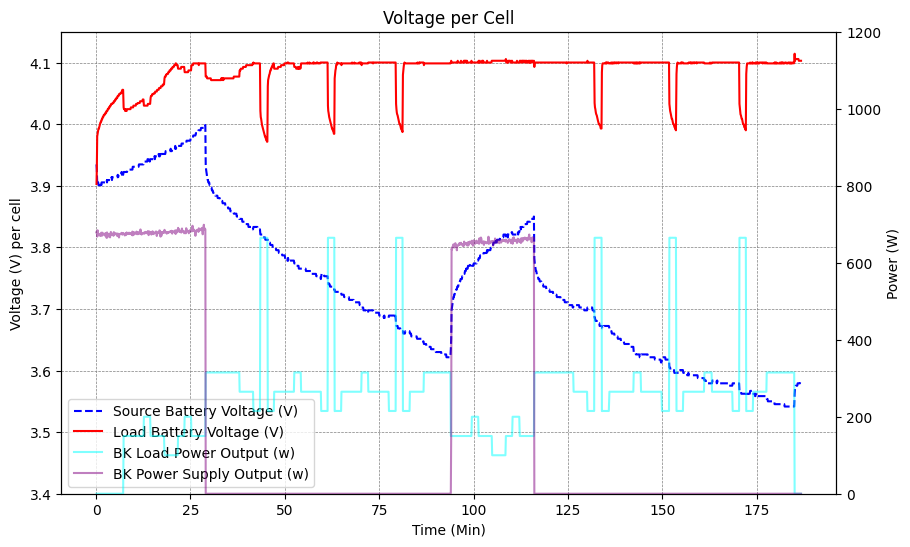

In [27]:
# Plot 3 - Battery Cells
fig, ax = plt.subplots(figsize=(10, 6))
line1, = ax.plot(df["Time"], df["Transmit Battery Voltage (V)"]/13, label="Source Battery Voltage (V)", color="blue", linestyle="dashed")  # TE has 13 cells
line2, = ax.plot(df["Time"], df['Load Battery Voltage (V)']/7, label="Load Battery Voltage (V)", color="red")  # LE has 7 cells
ax.set_xlabel('Time (Min)')  # Set the x-axis label
ax.set_ylabel('Voltage (V) per cell')  # Set the y-axis label
ax.set_title('Voltage per Cell')  # Set the title
ax.legend()  # Add a legend
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.set_ylim(3.4, 4.15)

ax2 = ax.twinx()
# Plot Load
# Opacity = 0.5
line3, = ax2.plot(df["Time"], df['BK Load Power (W)'], label="BK Load Power Output (w)", color="cyan", alpha=0.5)  # Plot the updated data )
line4, = ax2.plot(df["Time"], df['PS Power (W)'], label="BK Power Supply Output (w)", color="purple", alpha = 0.5)
ax2.set_ylabel('Power (W)')  # Set the y-axis label
ax2.set_ylim(0, 1200)

lines = [ line1, line2, line3, line4]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels)



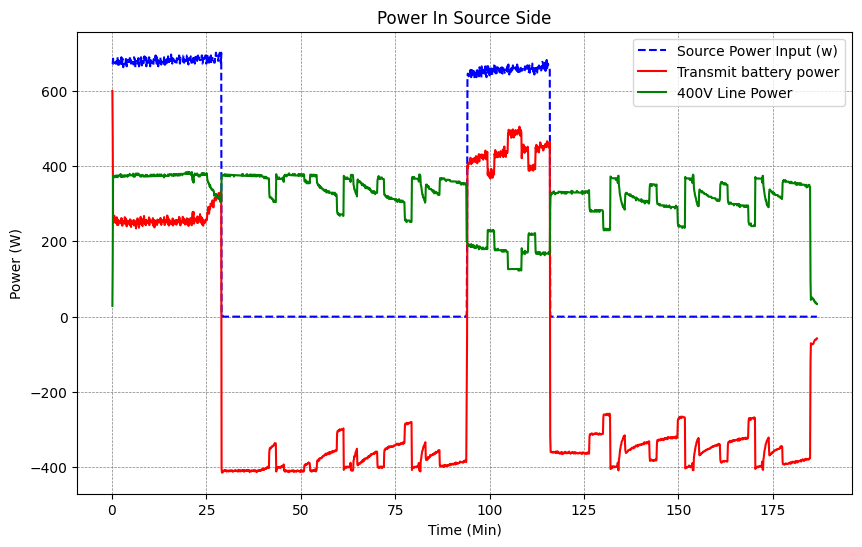

In [19]:
# Source side
fig, ax = plt.subplots( figsize=(10, 6))
ax.plot(df["Time"], np.multiply(df["Source in Voltage (V)"], df["Source in Current (A)"]), label="Source Power Input (w)", color="blue", linestyle="dashed")  # Plot the updated data
ax.plot(df["Time"], np.multiply(df["Transmit Battery Voltage (V)"], df["Transmit Battery Current (A)"]), label="Transmit battery power", color="red")  # Plot the updated data
ax.plot(df["Time"], np.multiply(df["400 Line Voltage (V)"], -1 * df["400 Line Current (A)"]), label="400V Line Power", color="green")  # Plot the updated data
ax.set_xlabel('Time (Min)')  # Set the x-axis label
ax.set_ylabel('Power (W)')  # Set the y-axis label
ax.set_title('Power In Source Side')  # Set the title
ax.legend()  # Add a legend
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)



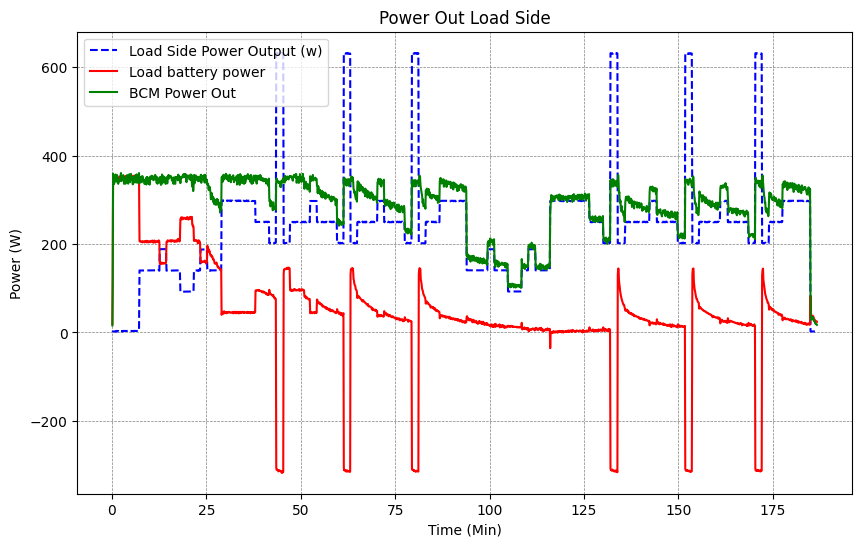

In [20]:
# Load side
fig, ax = plt.subplots( figsize=(10, 6))

bcm_power_out = np.multiply(df['BCM Voltage Out (V)'], df['BCM Current Out (A)'])
bcm_power_out.replace(0, np.nan, inplace=True)
bcm_power_out.interpolate(inplace=True)
bcm_power_out = bcm_power_out.to_numpy()
# reformat from shape (2222, ) to (2222, 1)
bcm_power_out = np.reshape(bcm_power_out, (bcm_power_out.shape[0], 1))

ax.plot(df["Time"], np.multiply(df['BK Load Voltage (V)'], df['Load Side Current (A)']), label="Load Side Power Output (w)", color="blue", linestyle="dashed")  # Plot the updated data
ax.plot(df["Time"], np.multiply(df['Load Battery Voltage (V)'], df["Load Battery Current (A)"]), label="Load battery power", color="red")  # Plot the updated data
ax.plot(df["Time"], bcm_power_out, label="BCM Power Out", color="green")  # Plot the updated data
ax.set_xlabel('Time (Min)')  # Set the x-axis label
ax.set_ylabel('Power (W)')  # Set the y-axis label
ax.set_title('Power Out Load Side')  # Set the title
ax.legend()  # Add a legend
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)